https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter12_part02_deep-dream.ipynb

best results 300x300 -> 400x400

In [1]:
from tensorflow import keras
import matplotlib.pyplot as plt

base_image_path = keras.utils.get_file(
    "coast.jpg", origin="https://img-datasets.s3.amazonaws.com/coast.jpg")

plt.axis("off")
plt.imshow(keras.utils.load_img(base_image_path))

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-48uoghke because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


450560/440742 [==============================] - 1s 1us/step


In [2]:
# from tensorflow.keras.applications import inception_v3
# m = inception_v3.InceptionV3(weights="imagenet", include_top=False)
# for l in m.layers:
#     print(l.name)

In [3]:
# model = keras.applications.xception.Xception(include_top=False) # -> xception_dream.png
# model = keras.models.load_model('data/models/xception_conv_base.keras') # -> xception_dream_2.png
model = keras.models.load_model('data/models/xception_fine_tuned.keras') # -> xception_dream_3.png

In [4]:
pool_layer_names = [l.name for l in model.layers if l.name.endswith('_pool')]
pool_layer_names

['block2_pool', 'block3_pool', 'block4_pool', 'block13_pool']

In [5]:
# for layer in model.layers:
#     print(layer.name)

In [6]:
# layer_name = pool_layer_names
# layer_names = [f'block{i}_sepconv2' for i in [11,12,13,14]]
layer_names = [f'block{i}_sepconv3' for i in [8,9,10,11]]
layer_settings = {k:v for k,v in zip(layer_names, [1.0,1.5,2.0,2.5])}
print(layer_settings)
outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

{'block8_sepconv3': 1.0, 'block9_sepconv3': 1.5, 'block10_sepconv3': 2.0, 'block11_sepconv3': 2.5}


In [7]:
def compute_loss(input_image):
    features = feature_extractor(input_image)
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :]))
    return loss

In [8]:
import tensorflow as tf

@tf.function
def gradient_ascent_step(image, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return loss, image


def gradient_ascent_loop(image, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, image = gradient_ascent_step(image, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print(f"... Loss value at step {i}: {loss:.2f}")
    return image

In [9]:
step = 20.
num_octave = 3
octave_scale = 1.4
iterations = 30
max_loss = 15.

In [10]:
import numpy as np

def preprocess_image(image_path):
    img = keras.utils.load_img(image_path)
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.inception_v3.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((img.shape[1], img.shape[2], 3))
    img /= 2.0
    img += 0.5
    img *= 255.
    img = np.clip(img, 0, 255).astype("uint8")
    return img

difference between fine tuned and imagenet is not significant - trying max_loss increase

In [22]:
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]

shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)
for i, shape in enumerate(successive_shapes):
    print(f"Processing octave {i} with shape {shape}")
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss*10 # TODO: xxx
    )
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

keras.utils.save_img("data/images/deep_dream/xception_dream_3.png", deprocess_image(img.numpy()))

Processing octave 0 with shape (459, 612)
... Loss value at step 0: 0.50
... Loss value at step 1: 0.79
... Loss value at step 2: 1.21
... Loss value at step 3: 1.61
... Loss value at step 4: 2.35
... Loss value at step 5: 2.90
... Loss value at step 6: 3.71
... Loss value at step 7: 4.85
... Loss value at step 8: 6.03
... Loss value at step 9: 7.61
... Loss value at step 10: 9.24
... Loss value at step 11: 10.72
... Loss value at step 12: 11.80
... Loss value at step 13: 14.42
... Loss value at step 14: 16.31
... Loss value at step 15: 19.66
... Loss value at step 16: 21.25
... Loss value at step 17: 25.97
... Loss value at step 18: 29.01
... Loss value at step 19: 30.61
... Loss value at step 20: 33.75
... Loss value at step 21: 36.92
... Loss value at step 22: 39.39
... Loss value at step 23: 42.62
... Loss value at step 24: 46.30
... Loss value at step 25: 47.78
... Loss value at step 26: 50.74
... Loss value at step 27: 54.74
... Loss value at step 28: 58.38
... Loss value at step

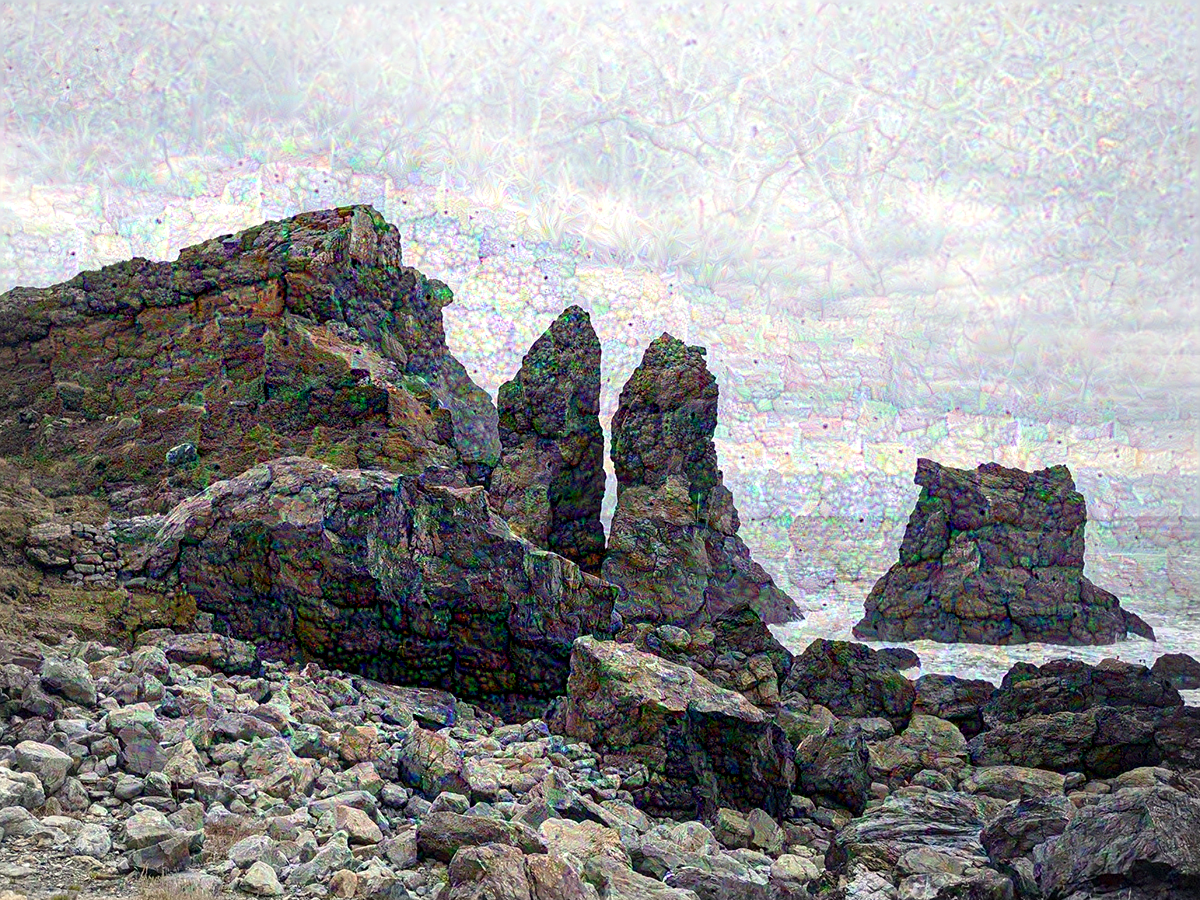

In [23]:
keras.utils.load_img("data/images/deep_dream/xception_dream_3.png")

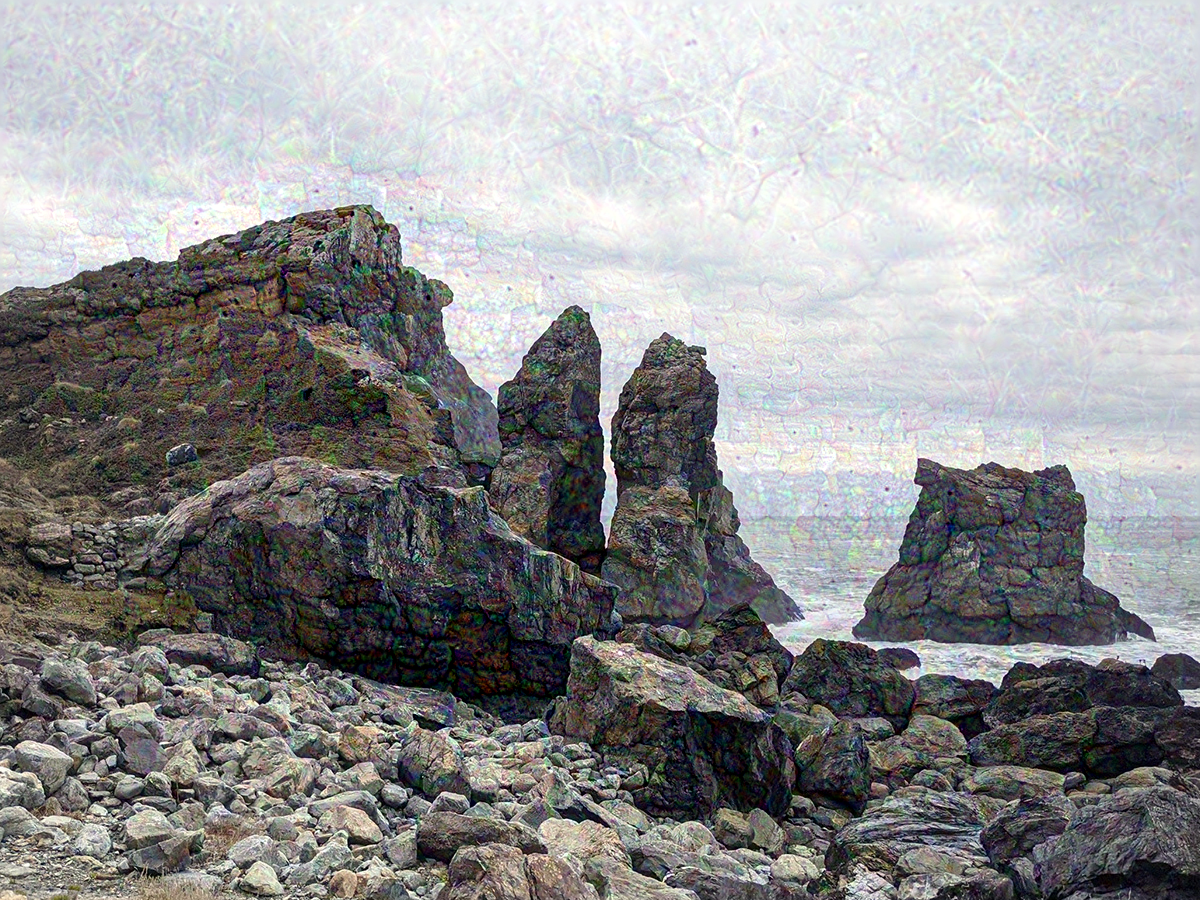

In [18]:
keras.utils.load_img("data/images/deep_dream/xception_dream_2.png")